In [372]:
# in the previous notebook we optimized a method for fitting dark 
# profiles to each pumped profile, in order to effectively
# obtain the difference scattering.

# Now, we can analyze how that difference scattering is changing with
# optical laser timing (time delay)


# Remember, this run we are analyzing represents opsin scattering, 
# and in theory opsin is a  photo-inactive protein, so any changes 
# we observe in the difference scattering should indicate solvent
# heating effects and other experimental factors

%matplotlib inline

import pandas
import numpy as np
import pylab as plt

In [373]:
# Lets load the dataframe we created in the last notebook

# This dataframe has difference profiles in it!
df = pandas.read_pickle("run656748_all_pumped.pkl")
print( list(df), len(df) )

(['tagNumber', 'time_of_getting_image[msec/tag]', 'time_of_detection[msec/tag]', 'time_of_writing_to_udb[msec/tag]', 'deriv_edge', 'fit_edge', 'memory_used[MB/core]', 'olaser_delay', 'olaser_volt', 'photon_energy', 'pulse_energy', 'radials', 'xlaser_joule_bm_1', 'pumped', 'time_adjust', 'delay_time', 'differences', 'residuals', 'dark_fits', 'success'], 4501)


In [374]:
# We stored some fit parameters, lets check how many times the fit failed
print("%d / %d successful fits"%( np.sum(df.success),len(df)))

# every fit report indicated a success, however maybe its not a good indication of 
# a good fit

4501 / 4501 successful fits


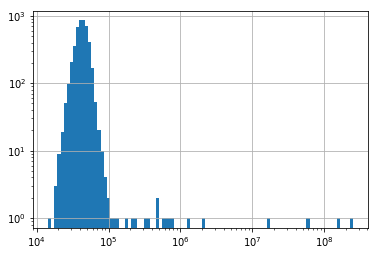

In [375]:
# Lets check the fit residuals

# We have to define log-spaced bins because the values vary across many orders
# of magnitude
bins = np.logspace( np.log10(df.residuals.min()), np.log10(df.residuals.max()), 100 )
df.residuals.hist(bins=bins, log=True)
plt.gca().set_xscale('log')

In [376]:
# Lets only keep bins that are bound by 1e4 < residual < 1e5
def filter_bad(df, column, lower, upper):
    values = df[column].values
    is_good = np.logical_and( lower < values, values < upper)
    df_good = df.loc[is_good]
    df_bad = df.loc[~is_good]
    return df_good, df_bad



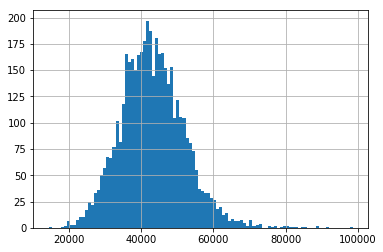

In [377]:
df_good, df_bad = filter_bad(df, 'residuals', 1e4, 1e5)
df_good.residuals.hist(bins=100)
# lets do a little more trimming

removed 65 / 4501 profiles


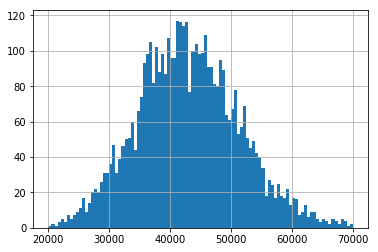

In [378]:
df_good, df_bad = filter_bad( df,'residuals', 2e4, 7e4)
df_good.residuals.hist(bins=100)
print("removed %d / %d profiles"%(len(df_bad), len(df)))

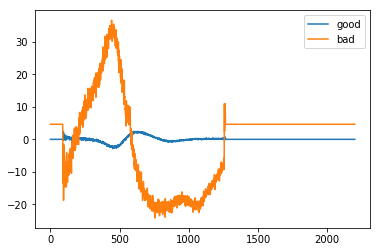

In [379]:
# Lets investigate what the bad difference profiles look like
plt.plot( df_good.differences.mean(0), label='good')
plt.plot( df_bad.differences.mean(0), label='bad')
plt.legend()
# Its a good thing we filtered

# Note the reason we know this is because the average difference profile
# looks as we would expect from typical water heating

Text(0,0.5,'Total number of measured shots')

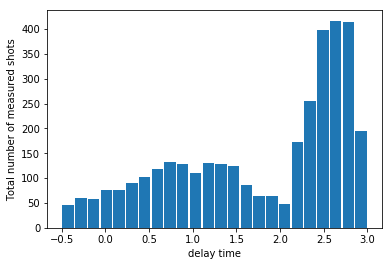

In [380]:
# Now, lets define some time bins:
tbins = np.linspace( -0.5, 3, 25)
times_x = tbins[1:]*.5 + tbins[:-1]*.5
delta_t = tbins[1] - tbins[0]
shots_per_tbin = [ len( df_good.query(" %.4f < delay_time <= %.4f"%(t,t+delta_t))) for t in tbins[:-1] ]


# Note, different "time bins" have different number of measurements
plt.bar( times_x, shots_per_tbin, width=.9*delta_t)
plt.xlabel("delay time")
plt.ylabel("Total number of measured shots")

In [381]:
# We can plot the difference profiles in time:


def get_diff_in_tbins(df, tbins):

    times_x = tbins[:-1]*.5 + tbins[1:]*.5
    delta_t = tbins[1]- tbins[0]
    diffs = []
    for t in times_x:
        t1 = t-delta_t*.5
        t2 = t+delta_t*.5
        d_t = df.query(" %.4f < delay_time < %.4f"%(t1,t2))
        diff = d_t.differences.mean(0)
        diffs.append( diff)
    return diffs


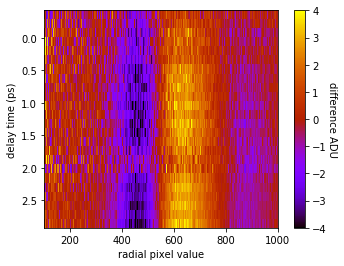

In [382]:
diffs = get_diff_in_tbins( df_good, tbins)

# Lets plot the diffs
plt.imshow( diffs , aspect=250, vmin=-4, vmax=4, 
           extent=( 0, len( diff), times_x[-1], times_x[0]),
          cmap='gnuplot')
plt.xlim(100,1000)
plt.ylabel("delay time (ps)")
plt.xlabel("radial pixel value")
_=plt.colorbar().ax.set_ylabel("difference ADU", rotation=270, labelpad=10)

In [383]:
# From the profiles it is clear that there is some kind of correlation between 
# number of measured points and amplitude of the difference signal

# Therefore it might be difficult to verify how REAL this signal is
# e.g. is it a quake due to solvent heating ???

# Lets look at the difference signal oscilation in a different way:

#######################################
# Lets plot the water heating signal 
#"peak-to-peak" as a function of delay time
###########################################

# We should smooth the difference signals first, so we need this filter
from scipy.signal import savgol_filter

# Lets make a function to do this peak to peak calculation
def peak_to_peak_diff( diff_signal, 
        min_roi = slice(400,500,None),
        max_roi = slice(575,675,None),
        savgol_window=101, savgol_degree=3, ax=None ):
    """
    finds the peak to peak distance in the water heating difference signal
    
    diff_signal: a difference profile, single shot or average is ok
    min_roi: region including the minimum peak
    max_roi: region including the maxium peak
    savgol_window, savgol_degree: filter parameters, 
        window size and polynomial degree
    ax: if provided, the smoother filter and peak positions will be plotted here
    """
    

    smooth_diff = savgol_filter(diff_signal, savgol_window, savgol_degree)
    arg_minval = smooth_diff[min_roi].argmin() + min_roi.start
    arg_maxval = smooth_diff[max_roi].argmax() + max_roi.start
     
    minval, maxval = smooth_diff[arg_minval], smooth_diff[ arg_maxval]
    
    peak_to_peak = maxval - minval
    
    if ax is not None:
        ax.plot( smooth_diff, )
        ax.plot( [arg_minval, arg_maxval], [minval, maxval], 'ko', ms=5, mfc='none', mew=2 )
    
    return peak_to_peak



(100, 1000)

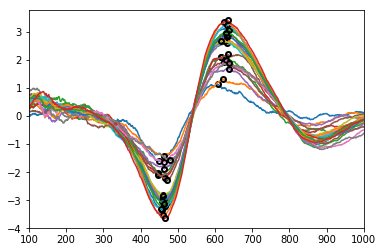

In [384]:
# make an axis for plotting
_, ax = plt.subplots(1,1)

# compute the peak to peaks:
peak_to_peaks = []
for diff in diffs:
    p2p = peak_to_peak_diff( diff, ax=ax)
    peak_to_peaks.append( p2p)
plt.xlim(100,1000)

# seems like the peak to peaks algorithm is working!

Text(0,0.5,'peak-to-peak difference signal')

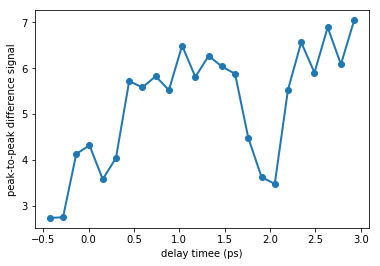

In [385]:
# Now lets see what the peak-to-peak values look like in time
plt.plot( times_x, peak_to_peaks, marker='o', lw=2)
plt.xlabel("delay timee (ps)")
plt.ylabel("peak-to-peak difference signal")

# we should investigate whether that signal is real!

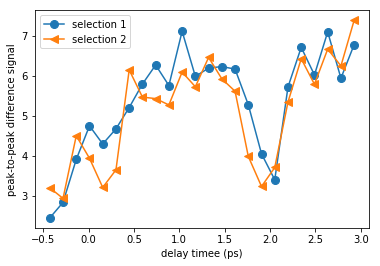

In [386]:
# there is clearly some kind of dip that is potentially interesting

# We can divie the data in two and see if the dip persists
Nrows = len( df_good)
rows_shuff = np.random.permutation( Nrows)

#rows_shuff[:Nrows]
df1 = df_good.iloc[rows_shuff[:Nrows/2] ] 
df2 = df_good.iloc[rows_shuff[Nrows/2:] ] 

diffs1 = get_diff_in_tbins( df1, tbins)
diffs2 = get_diff_in_tbins(df2, tbins)

peak_to_peaks1 = [ peak_to_peak_diff(d) for d in diffs1 ]
peak_to_peaks2 = [ peak_to_peak_diff(d) for d in diffs2 ]

plt.plot( times_x, peak_to_peaks1, marker='o', ms=8 ,label="selection 1")
plt.plot( times_x, peak_to_peaks2, marker='<', ms=8,label="selection 2")
plt.xlabel("delay timee (ps)")
plt.ylabel("peak-to-peak difference signal")
plt.legend()

Text(0,0.5,'peak-to-peak difference signal')

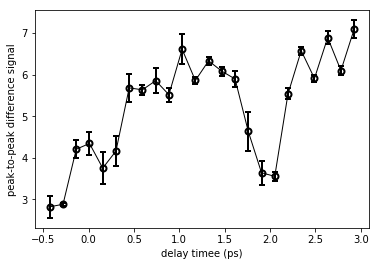

In [387]:
# we can plot error bar:
error = np.std( [peak_to_peaks1, peak_to_peaks2], 0) / np.sqrt(2)
signal = np.mean(  [peak_to_peaks1, peak_to_peaks2], 0)
plt.errorbar( times_x, signal, yerr=error, lw=1,color='k',
            capsize=3, capthick=2,ecolor='k',elinewidth=2,
             marker='o', mew=2,mec='k', mfc='none')
plt.xlabel("delay timee (ps)")
plt.ylabel("peak-to-peak difference signal")

In [ ]:

##############################
# BELOW IS A WORK IN PROGRESSS
##############################

Text(0.5,0,'delay time (ps)')

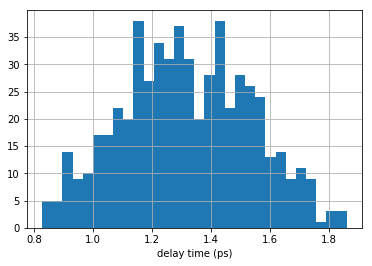

In [388]:
# note the precise time-delays per nominal time-delay
# vary quite a bit:

# e.g.
df_good.query("olaser_delay==200").delay_time.hist(bins=30)

plt.xlabel("delay time (ps)")

Text(0.5,0,'delay time (ps)')

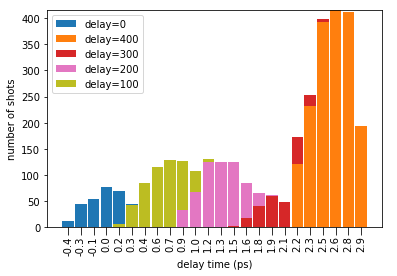

In [398]:
# based on the above, even though the nominal delay was roughly
# 1.3 ps, we measured delay times +- 500 femtoseconds

# We can use this variation as a control

# It would be interesting , e.g. to see what the 1.9 ps delay values look like
# when the nominal delay is either 1.6 ps or 2.2 ps.. for example

# They should be equivalent, save any systematic error

# Lets see the shots per time bin as a function of nominal delay
from collections import Counter
good_delays = [ k for k,v in Counter( df_good.olaser_delay).items() if v > 10]


df_good2 = df_good.loc[df_good.olaser_delay.isin( good_delays), :]

bottom = np.zeros( times_x.shape[0])

colors = {}
for i_delay, delay in enumerate(good_delays):
    if delay < 0:
        continue
    
    df_delay = df_good2.query("olaser_delay==%d"%delay)
    
    shots_per_delay,_ = np.histogram( df_delay.delay_time, bins=tbins )
    
    color = "C%d"%i_delay
    plt.bar(times_x, shots_per_delay, 
            bottom=bottom,color=color ,
            width=0.9*delta_t, label="delay=%d"%delay)

    bottom = shots_per_delay
    
    colors[delay]=color
    
plt.gca().set_xticks(times_x)
xlabs = np.round( times_x,1)
plt.gca().set_xticklabels(xlabs)
plt.gca().tick_params(axis='x', rotation=90, length=8, pad=0)
plt.legend()
plt.ylabel("number of shots")
plt.xlabel("delay time (ps)")

In [391]:
# for example it would be interesting to view
# time delay 2.2 ps when olaser_delay is either 300 or 400

# The results should be similar...

# lets assign a bin ID to the dataframe

tbin_id = np.digitize( df_good2.delay_time, tbins  )
tbin_label = [xlabs[i-1] if i>0 and i < len( tbins) else np.nan for i in tbin_id]
df_timelabeled = df_good2.copy()
df_timelabeled['tbin_label'] = tbin_label

In [400]:
def plot_tbins_overlaps(tbin_label):
    df_lab = df_timelabeled.query("tbin_label==%.3f"%tbin_label)
    for delay in df_lab.olaser_delay.unique():
        d = df_lab.query("olaser_delay==%d"%delay)
        plt.plot( d.differences.mean(0), 
                label="delay=%d; %d shots"%(delay, len(d)),
                color=colors[delay])

    plt.xlim(100,1000)
    plt.legend()

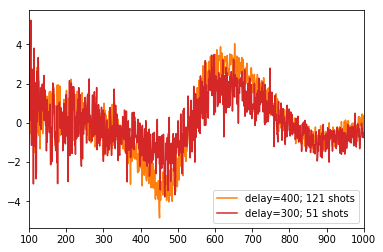

In [401]:
plot_tbins_overlaps(2.2)

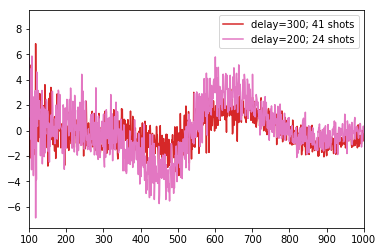

In [402]:
plot_tbins_overlaps(1.8)

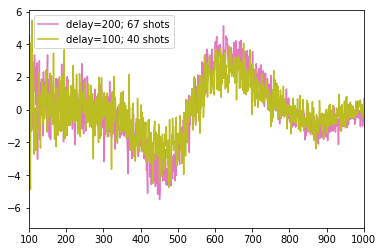

In [403]:
plot_tbins_overlaps(1)